In [ ]:
from tqdm import tqdm
from google.colab import drive
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from queue import Queue
import cv2
from scipy import signal
import pandas as pd


import skimage
from skimage import exposure, restoration
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.filters import threshold_otsu
from skimage.morphology import skeletonize

In [ ]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/PIB TP FINAL'

In [ ]:
path_vicky = path + '/DME-37503-1.jpeg'
prueba_vicky =  cv2.imread(path_vicky,0)

In [ ]:
path_vicky2 = path +'/NORMAL-351109-1.jpeg'
prueba_vicky2 =  cv2.imread(path_vicky2,0)

In [ ]:
imageSize= 224
train_dir = path + '/OCT_sampled/train'
test_dir =  path + '/OCT_sampled/test'
test_dir2 =  path + '/OCT2017/test'
# ['DME', 'CNV', 'NORMAL', '.DS_Store', 'DRUSEN']

## Funciones

### Genéricas

In [ ]:
def show_image(imagenes, titles = None, num_cols = None, num_fils = None, size = (10,10), axis_on = 'off'):
  if num_cols == None and num_fils == None:
    fig,ax = plt.subplots(1,1,figsize=size)
    ax.imshow(imagenes, cmap="gray",vmin=0, vmax=255)
    if titles != None: ax.set_title(titles)
    #ax.axis('off')

  elif num_cols == 1:
    fig,ax = plt.subplots(num_fils,num_cols,figsize=size)
    for i in range(num_fils):
      k = i
      ax[i].imshow(imagenes[k], cmap="gray",vmin=0, vmax=255)
      if titles[k] != None: ax[i].set_title(titles[k])
      ax[i].axis(axis_on)

  elif num_fils == 1:
    fig,ax = plt.subplots(num_fils,num_cols,figsize=size)
    for i in range(num_cols):
      k = i
      ax[i].imshow(imagenes[k], cmap="gray",vmin=0, vmax=255)
      if titles[k] != None: ax[i].set_title(titles[k])
      ax[i].axis(axis_on)

  else:
    fig,ax = plt.subplots(num_fils,num_cols,figsize=size)
    for i in range(num_fils):
      for j in range(num_cols):
        k = i * num_cols + j
        if k < len(imagenes):
          ax[i,j].imshow(imagenes[k], cmap="gray",vmin=0, vmax=255)
          if titles[k] != None: ax[i,j].set_title(titles[k])
          ax[i,j].axis(axis_on)
  plt.tight_layout()
  plt.show()

In [ ]:
def show_tagged(im, et, size = (15,10)):
  plt.figure(figsize=size)
  plt.subplot(121)
  plt.imshow(im, cmap='gray', vmin=0, vmax=255)
  plt.title('Imagen',fontsize=15)
  plt.subplot(122)
  plt.imshow(et, cmap='nipy_spectral')
  plt.title('Etiquetada',fontsize=15)
  plt.show()

In [ ]:
def image_histogram(image, normalize = False):
    histogram = np.zeros(256, dtype=int)  # Inicializamos el histograma como un arreglo de 256 ceros.
    for row in image:
      for pixel_value in row:
        histogram[int(pixel_value)] += 1   # Recorremos la imagen y contamos la frecuencia de cada nivel de gris.
    if normalize == True:
      histogram = histogram.astype(float) / np.sum(histogram)
    return histogram

In [ ]:
def plot_histogram(image, normalize = True):
  histogram = image_histogram(image)
  if normalize == True: histogram = histogram.astype(float) / np.sum(histogram)   # Normalizamos el histograma dividiendo por la cantidad total de pixeles

  plt.bar(range(len(histogram)), histogram, color='gray')   # Creamos el histograma de barras

  plt.title('Histograma de la Imagen')
  plt.xlabel('Valor del Píxel')
  plt.ylabel('Frecuencia')
  plt.show()

  return histogram

In [ ]:
def cumulated_histogram(imagen1, normalize = False, plot = False):
  imagen = imagen1.astype(np.uint8)
  histograma = image_histogram(imagen, normalize = normalize)
  histograma = np.squeeze(histograma)
  cum = np.zeros_like(histograma)
  for i in range(len(histograma)):
    cum[i] = np.sum(histograma[0:i])
  if plot:
    plt.plot(np.arange(0,len(histograma)), cum)
    plt.title('Histograma cumulativo de la Imagen')
    plt.xlabel('Valor del Píxel')
    plt.ylabel('Frecuencia')
    plt.show()
  return cum

### Descarga de datos

In [ ]:
def get_data(folder, imageSize):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    filenames = []

    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName == 'NORMAL':
                label = 0
            elif folderName == 'CNV':
                label = 1
            elif folderName == 'DME':
                label = 2
            elif folderName == 'DRUSEN':
                label = 3
            else:
                label = 4  # Esto es un valor de etiqueta predeterminado si hay otras carpetas

            print(tqdm(os.listdir(os.path.join(folder, folderName))))
            flag = 0
            for image_filename in tqdm(os.listdir(os.path.join(folder, folderName))):
                filenames.append(image_filename)
                img_file = cv2.imread(os.path.join(folder, folderName, image_filename),0)
                if img_file is not None:
                    img_file = cv2.resize(img_file, (imageSize, imageSize))   # Ajustar tamaño de la imagen
                    img_file = img_file.astype('uint8')
                    X.append(img_file)
                    y.append(label)

    filenames = np.array(filenames)
    X = np.asarray(X)
    y = np.asarray(y)

    return X, y, filenames

### Mejoramiento y Segmentación

In [ ]:
def gauss(x,y, sigma):
  return (1/(2*np.pi*sigma**2))*np.exp(-(x**2+y**2)/(2*sigma**2))

def kernel_gaussiano(n, sigma = 1):
  kernel = np.zeros((n,n))

  for i in range(len(kernel)):
    for j in range(len(kernel[0])):
      kernel[i,j] = gauss(i-n//2,j-n//2, sigma)

  return kernel

In [ ]:
def preprocess_image(im, white_extr = False, white_thresh = 250):
  image = im.copy()

  if white_extr:
    image[image>white_thresh] = 0

  gaussian_filtered = cv2.GaussianBlur(image, (5, 5), 0)

  sigma_est = np.mean(estimate_sigma(gaussian_filtered))
  denoised = denoise_nl_means(gaussian_filtered, h=0.6 * sigma_est, sigma = sigma_est, fast_mode=False, patch_size=3, patch_distance=1)

  denoised = (255 * denoised).astype(np.uint8)

  equalized_image = cv2.equalizeHist(denoised)
  equalized_image[:,0] = 0
  equalized_image[:,-1] = 0
  equalized_image[0,:] = 0
  equalized_image[-1,:] = 0

  return denoised, equalized_image

In [ ]:
def binarizar(imagen, umbral, gray_levels = 256):
  binaria = np.zeros_like(imagen)
  filas, columnas = imagen.shape

  for i in range(filas):
    for j in range(columnas):
      f = imagen[i, j]
      if f >= umbral: binaria[i, j] = gray_levels - 1

  return binaria

In [ ]:
def cumulated_probability(image, clase_sup, clase_inf=0):
  cum_hist = cumulated_histogram(image, normalize = True)
  cum_probability = cum_hist[clase_sup] - clase_inf

  return cum_probability

In [ ]:
def class_mean(image, clase_sup, clase_inf=0):
  cum_hist = cumulated_histogram(image, normalize = True)
  class_av = 0
  for i in range(clase_inf, clase_sup):
    class_av += i * cum_hist[i]

  return class_av

In [ ]:
def inter_class_var(image, clase_sup, clase_inf=0, gray_levels = 256):
  global_av = class_mean(image, gray_levels-1)
  class_av = class_mean(image, clase_sup, clase_inf=clase_inf)
  class_prob = cumulated_probability(image, clase_sup, clase_inf=clase_inf)

  if class_prob*(1-class_prob) != 0: var = (global_av*class_prob - class_av)**2/(class_prob*(1-class_prob))
  else: var = 0

  return var

In [ ]:
def Otsu(image, gray_levels = 256):
  varianza = np.zeros(gray_levels)

  for t in range(1,gray_levels):
    varianza[t] = inter_class_var(image, t, gray_levels = gray_levels)

  t_opt = np.argmax(varianza)
  bin_image = binarizar(image, t_opt, gray_levels = gray_levels)

  return t_opt, bin_image

In [ ]:
def neighbours_analizer(seed, values, val, analyzed_pos, max_fil, max_col, num = 4):
  i, j = seed
  vecinos = [[i-1, j], [i+1, j], [i, j-1], [i, j+1]]

  if num == 8:
    vecinos.extend([[i-1, j-1], [i+1, j+1], [i-1, j+1], [i+1, j-1]])

  # Filtramos vecinos que están fuera de los límites de la imagen o ya fueron evaluados
  vecinos = [[x, y] for x, y in vecinos if 0 <= x < max_fil and 0 <= y < max_col and (x, y) not in analyzed_pos]
  vecinos = [[x, y] for x, y in vecinos if values[x,y] == val]

  return vecinos

In [ ]:
def etiquetado(image, value = 0, bin_val = 200, gray_levels = 256, bin = True, size_thresh = 0):
  if bin:
    # Paso 1: Binarizamos la imagen.
    umbral = threshold_otsu(image)
    bin = binarizar(image, umbral)

  else:
    bin = binarizar(image, bin_val)

  # Paso 2: Identificamos las coordenadas de los píxeles que son iguales a 0 o 255 (value)
  coord = np.argwhere(bin == value)
  # Estas coordenadas van a ser las distintas semillas que evaluamos para el etiquetado

  k = 1
  evaluated = set()  # En evaluated vamos a poner los pixeles que ya etiquetamos, para no re-evaluarlos
  result = np.zeros_like(image, dtype=np.uint64)

  while len(coord) != 0:
      seed = coord[-1]  # Tomamos el último elemento
      coord = coord[:-1]  # Eliminamos la semilla de la lista

      if tuple(seed) in evaluated:
          continue  # Pasamos a la siguiente semilla si ya ha sido evaluada

      neighbours = neighbours_analizer(seed, bin, value, evaluated, len(bin), len(bin[0]))

      if not neighbours:
          continue  # Pasamos a la siguiente semilla si no tiene vecinos

      while len(neighbours) != 0:
          i, j = seed
          result[i, j] = k

          seed = neighbours.pop()
          evaluated.add(tuple(seed))

          new_neighbours = neighbours_analizer(seed, bin, value, evaluated, len(bin), len(bin[0]))
          for neighbour in new_neighbours:
              evaluated.add(tuple(neighbour))
          neighbours.extend(new_neighbours)

      if size_thresh != 0:
        length = len(result[result == k])
        if length < size_thresh:
          result[result == k] = 0
          k -=1

      k += 1  # Cambiamos de etiqueta

  return(result)

In [ ]:
def fill(bin_im, im):
  new = np.zeros_like(bin_im)

  fils, cols = new.shape

  for j in range(cols):
    lim_sup = -1
    lim_inf = -1
    for i in range(fils):
      if bin_im[i,j] == 255 and lim_sup == -1:
        lim_sup = i

      elif bin_im[i,j] == 0 and lim_inf == -1:
        if np.all(bin_im[i:,j]==0):
          lim_inf = i

    new[lim_sup:lim_inf,j] = 1


  return new.astype("uint8")

In [ ]:
def calcular_bounding_boxes(original, matriz_etiquetada, gray_levels = 256, Plot=True, color=(0, 255, 0), alpha=0.5):
    objetos = np.unique(matriz_etiquetada)[1:]  # Ignoramos el valor 0 que representa el fondo
    bounding_boxes = []
    image_bounding_boxes = np.zeros_like(matriz_etiquetada, dtype=np.uint8)
    white = gray_levels - 1

    for objeto in objetos:
        # Encontrar las coordenadas de los píxeles pertenecientes al objeto
        coords_objeto = np.argwhere(matriz_etiquetada == objeto)

        # Calcular los límites de la bounding box
        fila_min = np.min(coords_objeto[:, 0])
        fila_max = np.max(coords_objeto[:, 0])
        col_min = np.min(coords_objeto[:, 1])
        col_max = np.max(coords_objeto[:, 1])

        bounding_boxes.append(((col_min, fila_min), (col_max, fila_max)))  # Formato: ((x1, y1), (x2, y2))

    superposicion = np.array(original.copy())
    superposicion = superposicion.astype(np.uint8)

    for box in bounding_boxes:
      cv2.rectangle(superposicion, box[0], box[1], (white, white, white), 2)  # Le hacemos un borde blanco a cada bounding box
      cv2.rectangle(superposicion, box[0], box[1], color, -1)  # Dibujamos cada bounding box sobre la imagen original

    # Combinamos las dos imágenes con transparencia
    original = original.astype(np.uint8)
    imagen_superpuesta = cv2.addWeighted(original, 1 - alpha, superposicion, alpha, 0)

    if Plot:
      plt.figure(figsize=(10, 10))
      plt.imshow(cv2.cvtColor(imagen_superpuesta, cv2.COLOR_BGR2RGB))
      plt.axis('off')
      plt.show()

    return imagen_superpuesta, bounding_boxes


In [ ]:
def bounding_box_size(bounding_box, nombre = 'objeto', show = True):
  # bounding_box es una tupla de la forma ((x1, y1), (x2, y2))
  x1, y1 = bounding_box[0]  # Coordenadas del vértice superior izquierdo
  x2, y2 = bounding_box[1]  # Coordenadas del vértice inferior derecho
  # Calculamos el ancho y el alto del rectángulo
  ancho = abs(x2+1 - x1)
  alto = abs(y2+1 - y1)

  if show:
    print(f'Ancho del {nombre}: {ancho} píxeles \nAlto del {nombre}: {alto} píxeles \nTamaño del {nombre}: {ancho*alto} píxeles cuadrados')
  return (ancho, alto, ancho*alto)

In [ ]:
def calculate_size(objects):
  sizes = []
  for obj in objects:
    mini = obj[0]
    maxi = obj[1]

    size = (maxi[0]-mini[0])*(maxi[1]-mini[1])
    sizes.append(size)

  return sizes

In [ ]:
def distancia_euclidea(v1, v2):
  return np.sqrt(np.sum((v1-v2)**2))

In [ ]:
def k_means(img, k, min_dsv = 10, max_iter = 100, gray_levels = 256, random_state = None, print_message = True):
  pixeles = np.ravel(img).astype('float')

  if random_state == None:
    centroides = np.random.choice(range(gray_levels), k, replace=False)
  else:
    random_generator = np.random.RandomState(random_state)
    centroides = random_generator.choice(range(gray_levels), k, replace=False)


  centroides = sorted(centroides)

  asignaciones = np.zeros(img.shape)

  for n in range(max_iter):

    for i in range(len(img)):
      for j in range(len(img[0])):
        distancias = [distancia_euclidea(img[i,j], centroide) for centroide in centroides]
        asignaciones[i,j] = np.argmin(distancias)

    nuevos_centroides = []
    for i in range(k):
        cluster_puntos = img[asignaciones == i]
        if len(cluster_puntos) != 0:
            nuevo_centroide = np.mean(cluster_puntos)
        else:
            nuevo_centroide = np.random.choice(pixeles)
        nuevos_centroides.append(nuevo_centroide)

    distancia_centroides = [distancia_euclidea(centroides[i], nuevos_centroides[i]) for i in range(k)]

    centroides = nuevos_centroides

    if np.max(distancia_centroides) < min_dsv:
      if print_message: print(f'Se cumplio la distancia minima {min_dsv}')
      break

  new_img = asignaciones

  return new_img

In [ ]:
def y_coord(etiquetas):
  etiquetas_unicas = np.unique(etiquetas)
  etiquetas_unicas = etiquetas_unicas[etiquetas_unicas != 0]  # Excluye la etiqueta de fondo (0)
  filas_promedio = [-1]

  for etiqueta in etiquetas_unicas:
    coordenadas = np.argwhere(etiquetas == etiqueta)

    filas = coordenadas[:, 0]
    fila_promedio = np.mean(filas)

    filas_promedio.append(fila_promedio)

  return filas_promedio

In [ ]:
def get_RPE(k_im, thresh = 500, show = False):
  k_im[:5,:] = 0
  k_im[-5:, :] = 0
  k_im[:,:5] = 0
  k_im[:,-5:] = 0
  EPR = np.zeros_like(k_im)
  EPR[k_im== np.max(np.unique(k_im))] = 255

  et_EPR = etiquetado(EPR, value=255, size_thresh = thresh)
  filas = y_coord(et_EPR)

  et_max = np.argmax(filas)
  EPR_fin = np.zeros_like(et_EPR)
  EPR_fin[et_EPR == et_max] = 255

  if show:
    show_image(EPR, titles = 'Centroide máximo')
    show_tagged(EPR, et_EPR)
    show_image(EPR_fin, titles = 'EPR detectado')

  return EPR_fin

In [ ]:
def skeletonize_image(image):
    skeleton = skeletonize(image // 255)  # Convertir a binario si no lo está
    return (skeleton * 255).astype(np.uint8)

In [ ]:
def best_fit_line(image):
  coords = np.column_stack(np.where(image == 255))
  if coords.size == 0:
    raise ValueError("No se encontraron píxeles con valor 255 en la imagen.")
  X = coords[:, 1]
  Y = coords[:, 0]
  A = np.vstack([X, np.ones(len(X))]).T
  m, c = np.linalg.lstsq(A, Y, rcond=None)[0]

  return X, Y, m, c

In [ ]:
def draw_best_fit_line(image, m, c, grey_val=150):
  line_image = np.copy(image)
  rows, cols = line_image.shape
  for x in range(cols):
    y = int(m * x + c)
    if 0 <= y < rows:
      line_image[y, x] = grey_val
  return line_image

In [ ]:
def best_fit_parabola(image):
  coords = np.column_stack(np.where(image == 255))
  if coords.size == 0:
    raise ValueError("No se encontraron píxeles con valor 255 en la imagen.")
  X = coords[:, 1]
  Y = coords[:, 0]

  A = np.vstack([X**2, X, np.ones(len(X))]).T
  a, b, c = np.linalg.lstsq(A, Y, rcond=None)[0]

  return X, Y, a, b, c

In [ ]:
def draw_best_fit_parabola(image, a, b, c, grey_val=150):
  parabola_image = np.copy(image)
  rows, cols = parabola_image.shape
  for x in range(cols):
    y = int(a * x**2 + b * x + c)
    if 0 <= y < rows:
      parabola_image[y, x] = grey_val
  return parabola_image

In [ ]:
def calculate_R2(X, Y, predicted_Y):
  ss_res = np.sum((Y - predicted_Y) ** 2)
  ss_tot = np.sum((Y - np.mean(Y)) ** 2)
  r_squared = 1 - (ss_res / ss_tot)
  return r_squared

### Generalización

In [ ]:
def pre_process(imagen, show_steps = False):
  den1, im1 = preprocess_image(imagen, white_extr = True)

  et1 = etiquetado(den1, value=255, bin = True)

  lengths1 = [len(et1[et1 == val]) for val in np.unique(et1[1:])]

  im2 = np.zeros_like(et1)
  val = np.unique(et1)[np.argmax(lengths1[1:])+1]
  im2[et1 == val] = 255

  im3 = fill(im2, imagen)*imagen

  if show_steps:
    show_image(den1, titles = 'Primer procesamiento')

    plt.figure(figsize=(15,10))
    plt.subplot(121)
    plt.imshow(den1, cmap='gray', vmin=0, vmax=255)
    plt.title('Imagen',fontsize=15)
    plt.subplot(122)
    plt.imshow(et1, cmap='nipy_spectral')
    plt.title('Etiquetada',fontsize=15)
    plt.show()

    show_image(im2, titles = 'Imagen binarizada')

    show_image(im3, titles = 'Imagen rellenada')

  im_obj, obj = calcular_bounding_boxes(im3,et1, Plot = show_steps)

  val_max = np.argmax(calculate_size(obj))
  bb1 = obj[val_max]

  im4 = im3[bb1[0][1]:bb1[1][1],bb1[0][0]:bb1[1][0]]

  if show_steps:
    show_image(im4, titles = 'Imagen final')

  return im4

In [ ]:
def vessels(im, thresh = 75, k_num = 3, max_iterat = 50, inform = False, show = False):
  kmeans_imagen = k_means(im, k_num, min_dsv = 4, max_iter = max_iterat, print_message = False)
  if np.max(np.unique(kmeans_imagen)) != 0:
    kk = kmeans_imagen*int(255/np.max(np.unique(kmeans_imagen)))
    kk[0,:] = 0
    kk[-1,:] = 0
    kk[:,0] = 0
    kk[:,-1] = 0
    etiquetado1 = etiquetado(kk, value=0, bin_val = 1, bin = False, size_thresh = thresh)
    if show:
      show_tagged(kk,etiquetado1)
    if inform:
      print(f'Se detectaron {(len(np.unique(etiquetado1))-2)} vasos en la retina.')
    return kk, etiquetado1,(len(np.unique(etiquetado1))-2)  #Restamos 1 por el fondo del etiquetado (objeto - retina) y 1 por el etiquetado normal (etiquetado del fondo)

  else:
    if inform:
      print(f'No se pudo realizar el procesamiento con éxito.')
    return kk, etiquetado1,-1

In [ ]:
def best_fit_corr(k_im, mode = 'straight', plot = False, inform = False):
  EPR = get_RPE(k_im, show = plot)
  skeleton = skeletonize_image(EPR)

  if plot: show_image(skeleton, titles = 'Esqueleto')

  if mode == 'straight':
    X, Y, m, c = best_fit_line(skeleton)
    predicted_Y = m * X + c
    line_sk = draw_best_fit_line(skeleton, m, c)
    line_epr = draw_best_fit_line(EPR, m, c)
    title_sk = "Esqueleto con Línea de Mejor Ajuste"
    title_epr = "Original con Línea de Mejor Ajuste"
  elif mode == 'parabolic':
    X, Y, a, b, c = best_fit_parabola(skeleton)
    predicted_Y = a * X**2 + b * X + c
    line_sk = draw_best_fit_parabola(skeleton, a, b, c)
    line_epr = draw_best_fit_parabola(EPR, a, b, c)
    title_sk = "Esqueleto con Parábola de Mejor Ajuste"
    title_epr = "Original con Parábola de Mejor Ajuste"

  if plot:
    show_image(line_sk, titles = title_sk)
    show_image(line_epr, titles = title_epr)

  r_squared = calculate_R2(X, Y, predicted_Y)

  if inform: print(f'Coeficiente de determinación (R2): {np.round(r_squared,3)}')

  return line_epr, r_squared


### Clasificación y Evaluación del Rendimiento

In [ ]:
def classify(cant, R, umbral_vessels, umbral_r):
  if cant > umbral_vessels:
    if R < umbral_r:
      diagnostico = 1 #CNV
    else:
      diagnostico = 2 #"DME"
  else:
    diagnostico = 0  # "retina normal

  return diagnostico

In [ ]:
def clasificacion_completa(imagen, umbral_vessels, umbral_r):
  diagnostico = None
  imagen_preprocesada = pre_process(imagen)
  imagen_vasos, etiquetado_vasos,cant_vasos= vessels(imagen_preprocesada)
  regresion_imagen, R_imagen = best_fit_corr(imagen_vasos, mode = 'parabolic')

  diagnostico = classify(cant_vasos, R_imagen, umbral_vessels, umbral_r)

  return diagnostico


In [ ]:
def clasificador(data,umbral_vessels,umbral_r):
  predicciones=[]
  for imagen in data:
    prediccion=clasificacion_completa(imagen,umbral_vessels=umbral_vessels,umbral_r=umbral_r)
    predicciones.append(prediccion)
  return predicciones

In [ ]:
def matriz_confusion(categorias, etiquetas, resultados, show = True):
  ind = categorias
  cols = categorias
  vals = np.zeros((len(categorias), len(categorias)))

  mat = pd.DataFrame(vals, index = ind, columns = cols, dtype=int)

  for j in range(len(etiquetas)):
    real = etiquetas[j]
    mat.loc[real][resultados[j]] += 1

  if show:
    print('Matriz de confusión - Cantidad de clasificaciones por categoría')
    display(mat)

  new_mat = mat.copy()
  for i in range(len(new_mat)):
    tot = np.sum(mat.iloc[i].values)
    for j in range(len(mat.columns)):
      if tot!=0:
        new_mat.iloc[i, j] = mat.iloc[i, j]*100 / tot
      else:
        new_mat.iloc[i, j] =0

  if show:
    print('Matriz de confusión - Porcentajes')
    display(new_mat)
  return new_mat,mat

In [ ]:
def calc_medidas(df):
  metricas = ['Accuracy', 'Precisión', 'Tasa de VP', 'Tasa de FP', 'F1-score']
  value = np.zeros((len(metricas),len(df)))
  cols = df.index.values
  results = pd.DataFrame(value, index = metricas, columns = cols)

  for i in range(len(df)):
    TP = df.iloc[i][df.index[i]]  # Verdaderos positivos
    FP = np.sum(df.iloc[:i][df.index[i]].values) + np.sum(df.iloc[i+1:][df.index[i]].values)  # Falsos positivos
    TN = np.sum(df.iloc[:i][df.index[:i]].values) + np.sum(df.iloc[i+1:][df.index[i+1:]].values)  # Verdaderos negativos
    FN = np.sum(df.iloc[i][df.index[:i]].values) + np.sum(df.iloc[i][df.index[i+1:]].values)  # Falsos negativos

    # Calculomos las métricas para la categoría particular
    acc = (TP+TN)/(TP+TN+FP+FN)
    if TP+FP != 0: pre = TP/(TP+FP)
    else: pre = 0

    if TP+FN != 0: t_VP = TP/(TP+FN)
    else: t_VP=0
    if FP+TN!= 0: t_FP = FP/(FP+TN)
    else: t_FP=0
    if pre+t_VP != 0: f1 = 2*pre*t_VP/(pre+t_VP)
    else: f1 = 0

    results[df.index[i]] = np.array([acc,pre,t_VP,t_FP,f1])

  return results

In [ ]:
import time

In [ ]:
def grid_search(param_grid, data, etiquetas):
    categorias = [0,1,2]
    param_names = list(param_grid.keys())
    umbral_vessels_values = param_grid['umbral_vessels']
    umbral_r_values = param_grid['umbral_r']

    param_combinations = []

    for uv in umbral_vessels_values:
        for ur in umbral_r_values:
            combination = [uv, ur]
            param_combinations.append(combination)

    metricas = []
    total_combinations = len(param_combinations)

    start_time = time.time()
    valores=[]
    for image in data:
        imagen_preprocesada = pre_process(image)
        imagen_vasos, etiquetado_vasos,cant_vasos= vessels(imagen_preprocesada)
        lineaR, R_imagen = best_fit_corr(imagen_vasos, mode = 'parabolic')
        valor = [cant_vasos, R_imagen]
        valores.append(valor)

    for idx, combination in enumerate(param_combinations):
        iteration_start_time = time.time()
        predicciones = []
        for i in range(len(valores)):
          prediccion=classify(valores[i][0],valores[i][1],combination[0],combination[1])
          predicciones.append(prediccion)


        mat = matriz_confusion(categorias, etiquetas, predicciones,show=False)
        metric = calc_medidas(mat[1])

        metricas.append({'parametros': combination, 'metricas': metric})

        iteration_end_time = time.time()
        iteration_time = iteration_end_time - iteration_start_time

        # Estimate remaining time
        elapsed_time = iteration_end_time - start_time
        remaining_combinations = total_combinations - (idx + 1)
        estimated_remaining_time = remaining_combinations * iteration_time

        print(f"Combinación {idx + 1}/{total_combinations} procesada.")
        print(f"Tiempo estimado restante: {estimated_remaining_time:.2f} segundos.")

    return metricas

In [ ]:
def average(metricas):
  prom = []
  cols = []
  idx = metricas[0]['metricas'].index
  for i in range(len(metricas)):
    parametros = metricas[i]['parametros']
    param = f'Threshold_vessels:  {str(parametros[0])}. Threshold_R2: {str(parametros[1])}.'
    valores = metricas[i]['metricas'].values
    promedios = [np.mean(valor) for valor in valores]
    prom.append(promedios)
    cols.append(param)

  promedios_finales = [list(fila) for fila in zip(*prom)]
  df_prom = pd.DataFrame(promedios_finales, index = idx, columns = cols)
  return df_prom

## Implementación

In [ ]:
X_train, y_train, files_train = get_data(train_dir, imageSize)
X_test, y_test, files_test = get_data(test_dir, imageSize)

  0%|          | 0/25 [00:00<?, ?it/s]


  0%|          | 0/25 [00:00<?, ?it/s]


  0%|          | 0/25 [00:00<?, ?it/s]


  0%|          | 0/25 [00:00<?, ?it/s]


  0%|          | 0/25 [00:00<?, ?it/s]


  0%|          | 0/25 [00:00<?, ?it/s]


  0%|          | 0/25 [00:00<?, ?it/s]


  0%|          | 0/25 [00:00<?, ?it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


  0%|          | 0/94 [00:00<?, ?it/s]


  0%|          | 0/94 [00:00<?, ?it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:01<00:00, 50.70it/s]


Analizamos en qué posición se descargan las imágenes, considerando que las etiquetas siguen el siguiente código:


*   0: Normal
*   1: CNV
*   2: DME
*   3: Drusen



In [ ]:
y_train[0], y_train[26], y_train[51], y_train[76]

(1, 3, 0, 2)

In [ ]:
y_test[0], y_test[101], y_test[201], y_test[301]

(1, 0, 3, 2)

Debido a que el alcance de este proyecto no busca diagnosticar la instancia de Drusen, removemos las imágenes correspondientes a esta condición.

In [ ]:
nuevo_X_train, nuevo_y_train = np.concatenate((X_train[0:25], X_train[50:])), np.concatenate((y_train[0:25], y_train[50:]))

In [ ]:
nuevo_X_test, nuevo_y_test = np.concatenate((X_test[0:25], X_test[100:125], X_test[300:325])), np.concatenate((y_test[0:25], y_test[100:125], y_test[300:325]))

In [ ]:
X_test_nuevo, y_test_nuevo = np.concatenate((X_test[50:75], X_test[150:175], X_test[350:375])), np.concatenate((y_test[50:75], y_test[150:175], y_test[350:375]))

Luego, probamos las distintas instancias del algoritmo en diferentes imágenes.

### Pre-procesamiento

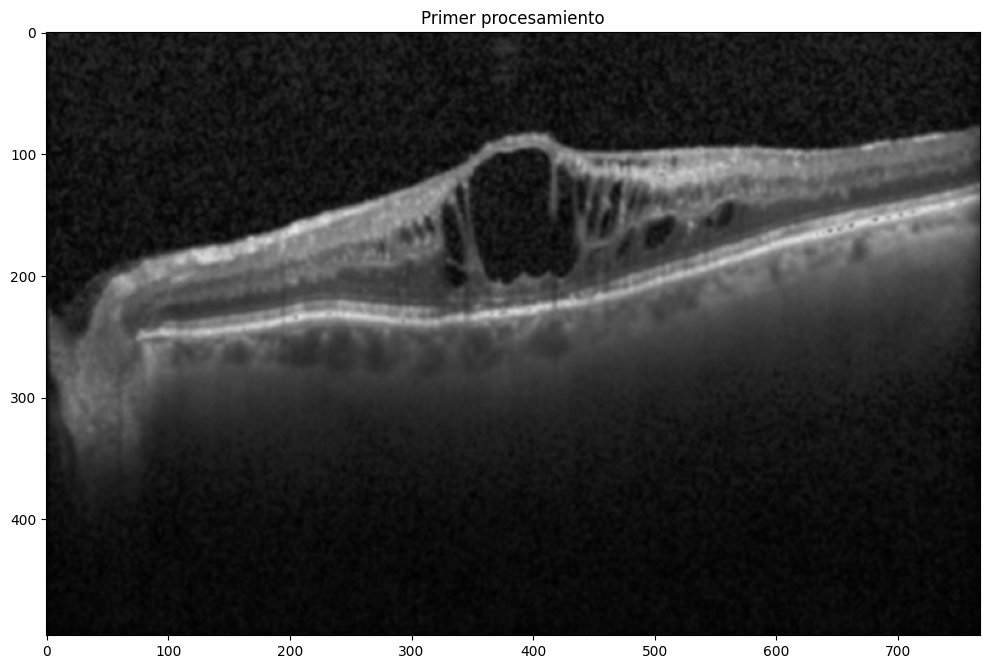

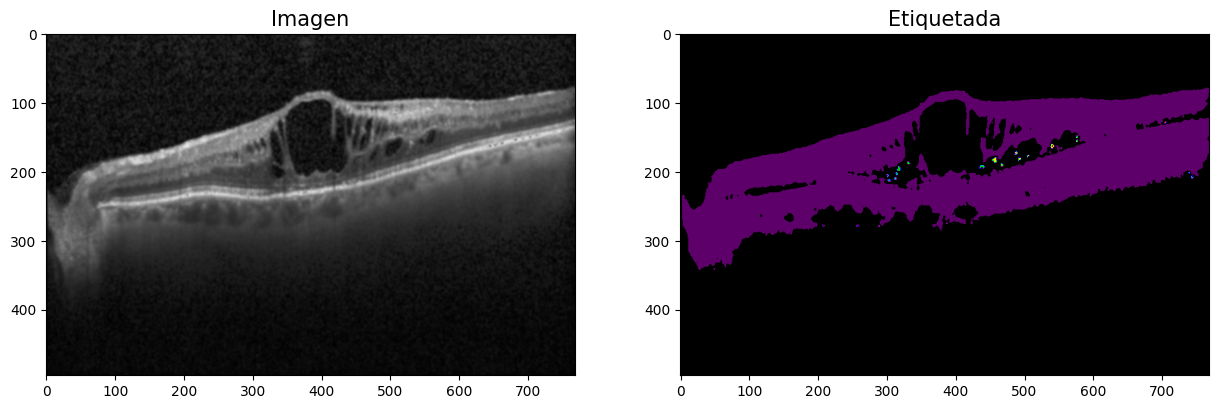

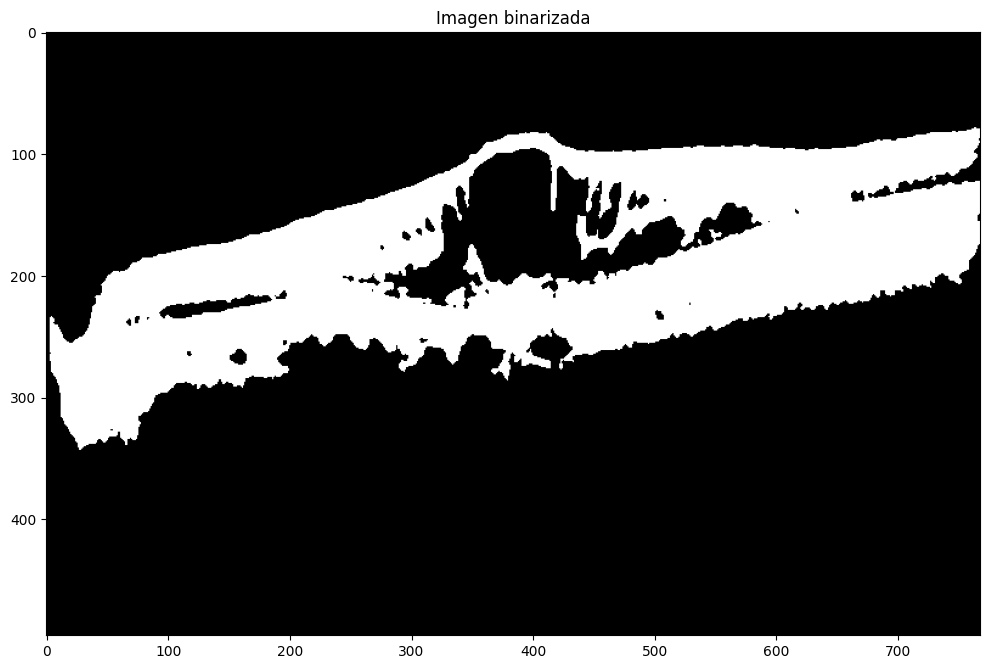

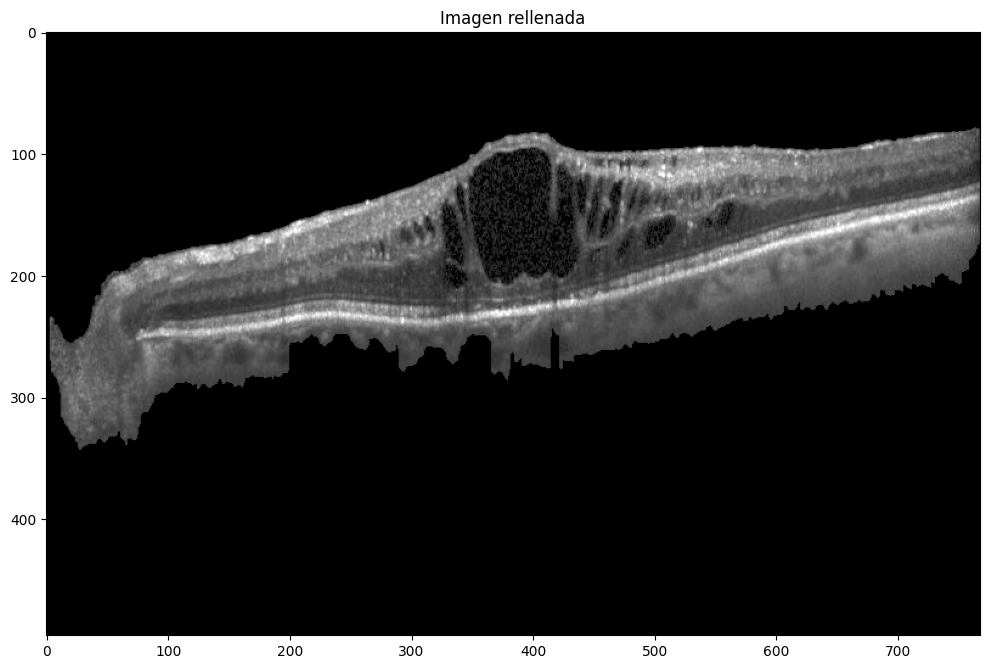

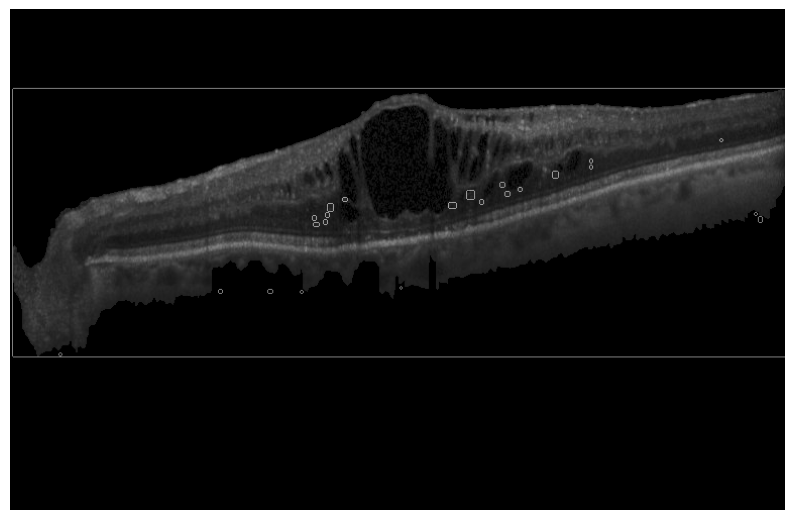

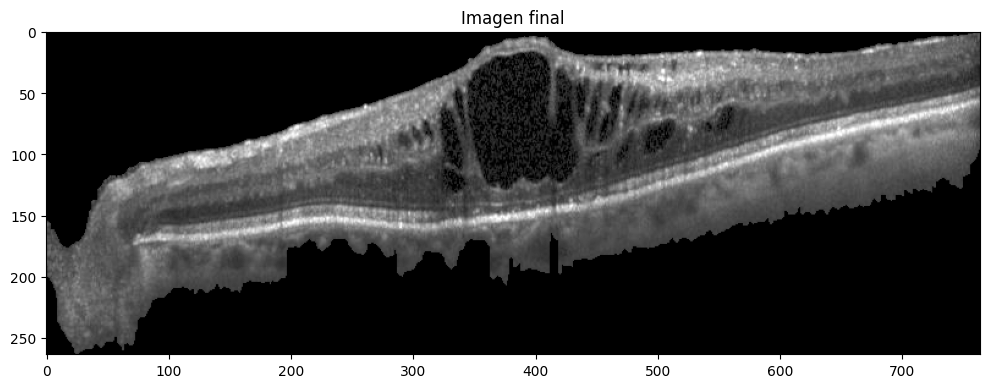

In [ ]:
nueva_vi = pre_process(prueba_vicky, show_steps=True)

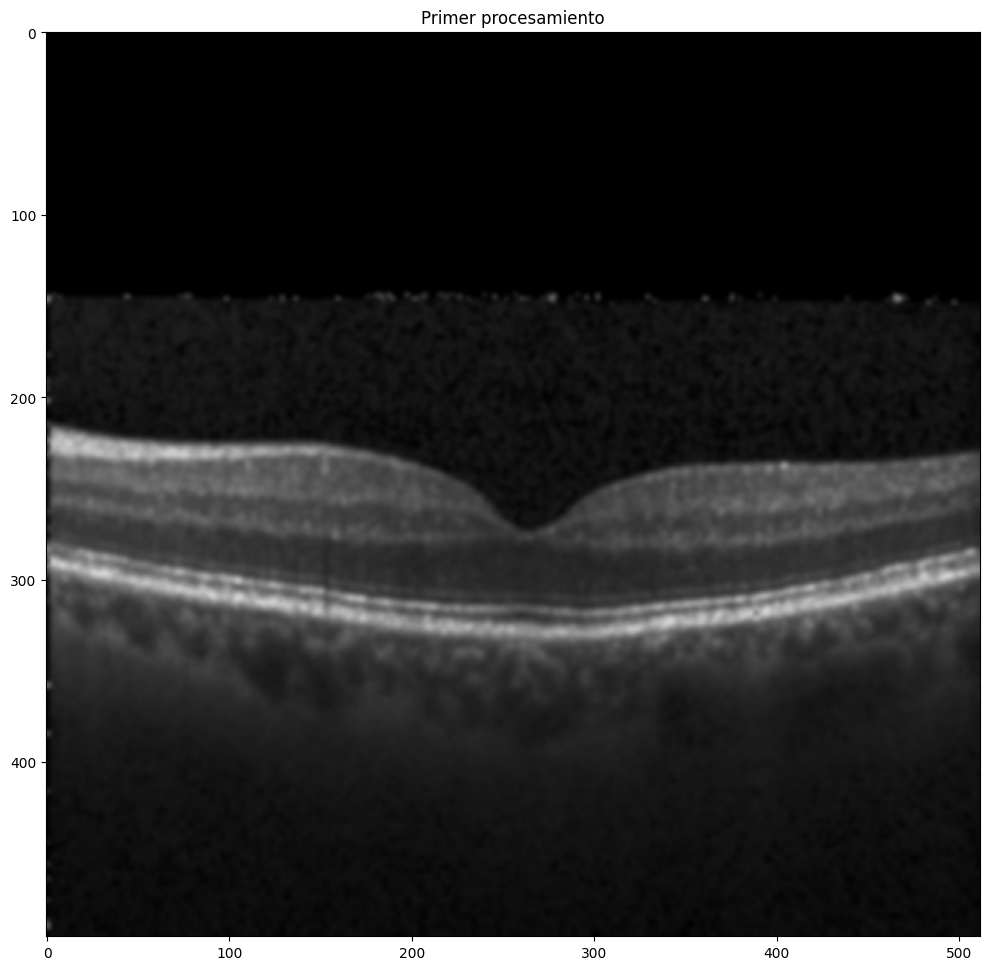

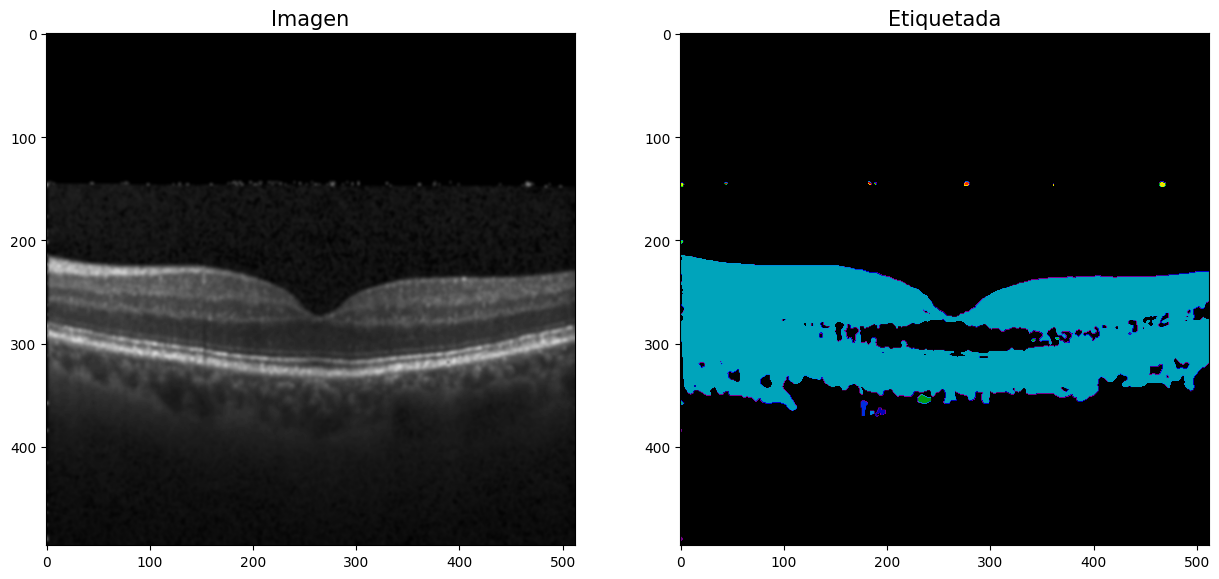

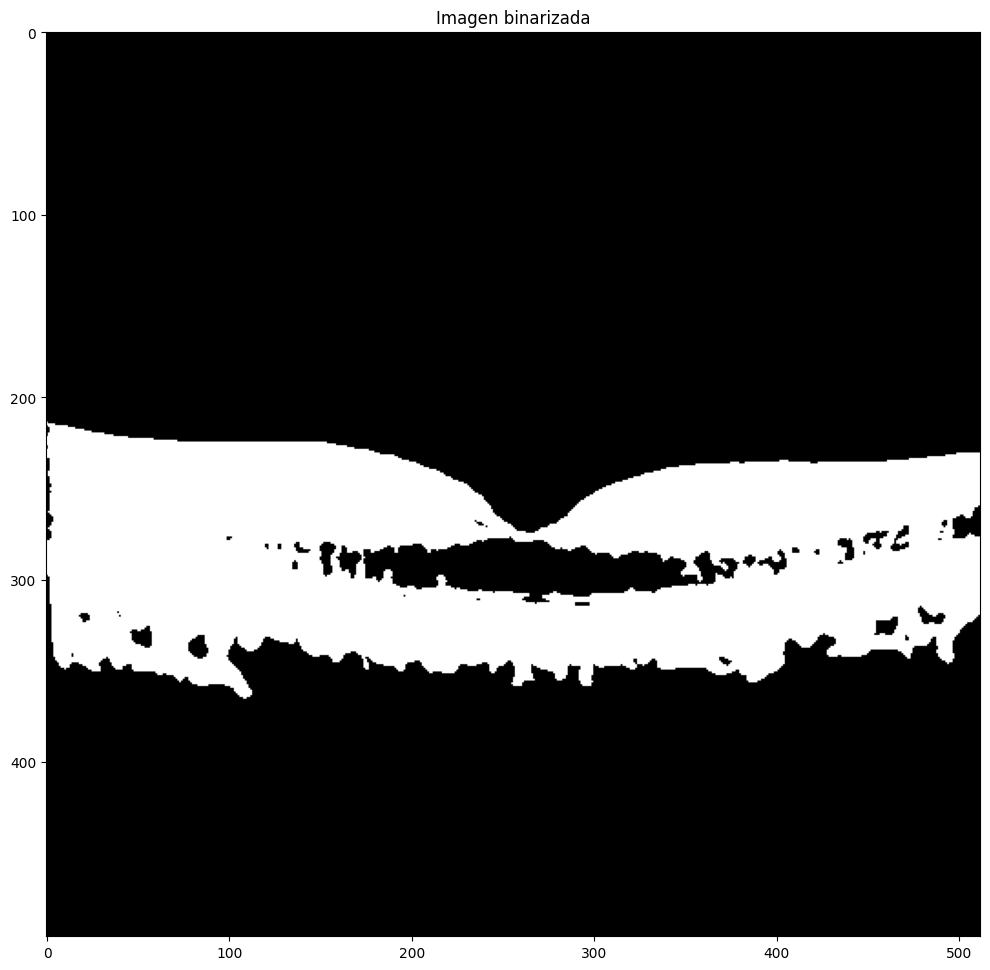

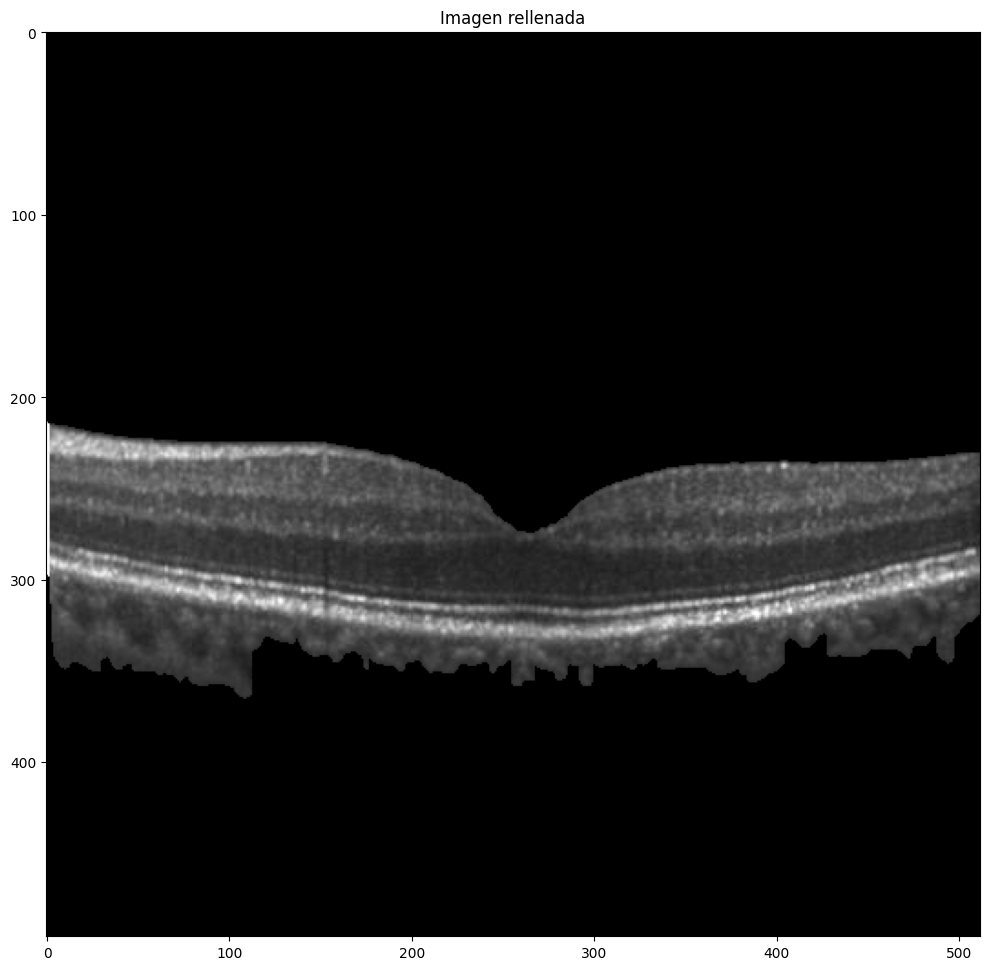

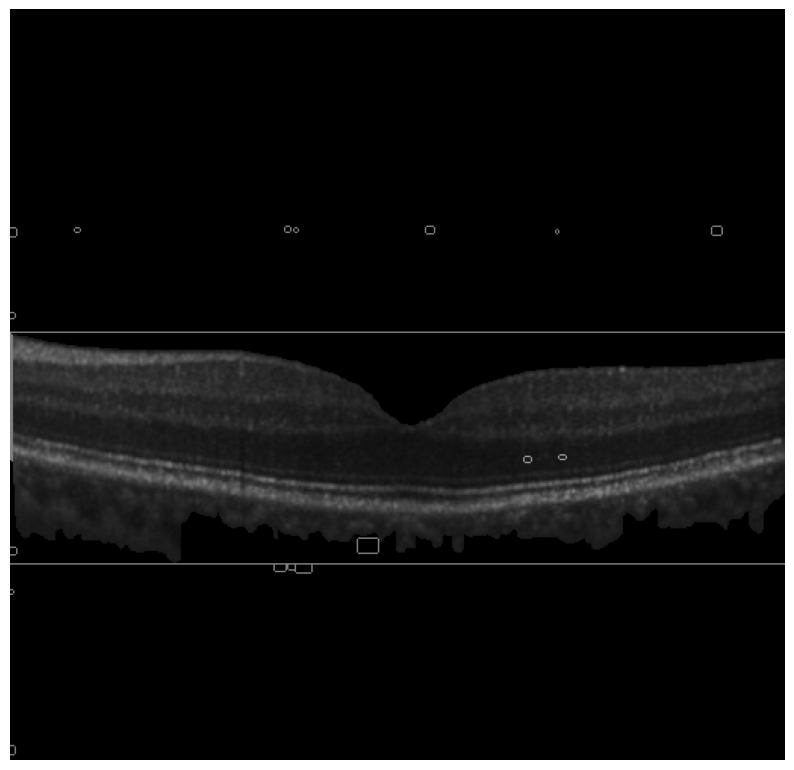

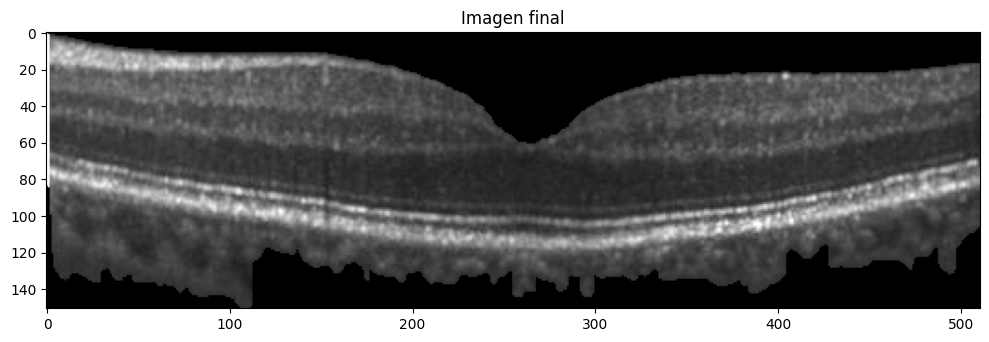

In [ ]:
nueva_vi2 = pre_process(prueba_vicky2, show_steps=True)

### Conteo de vasos

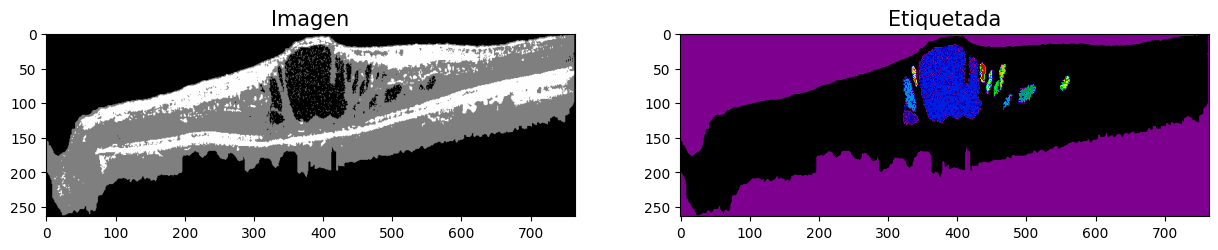

Se detectaron 13 vasos en la retina.


In [ ]:
vessels_vi = vessels(nueva_vi, inform = True, show=True)

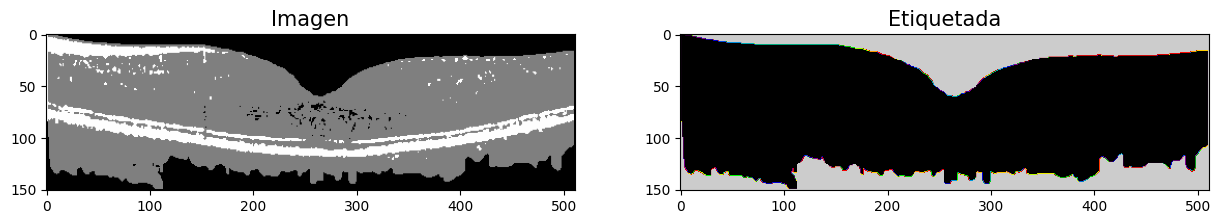

Se detectaron 0 vasos en la retina.


In [ ]:
vessels_vi2 = vessels(nueva_vi2, inform = True, show = True)

### Análisis del EPR (Epitelio Pigmentario de la Retina)

#### Basado en la Regresión Lineal

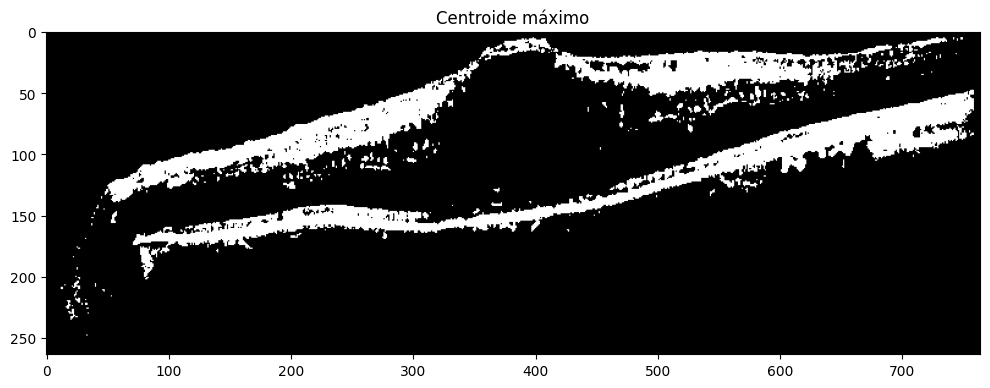

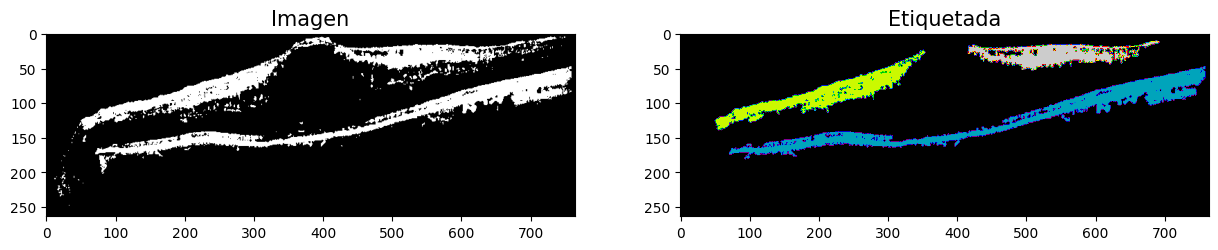

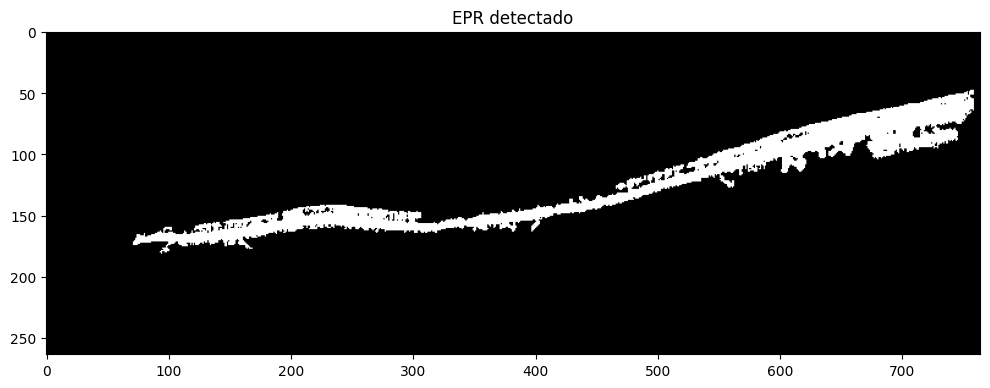

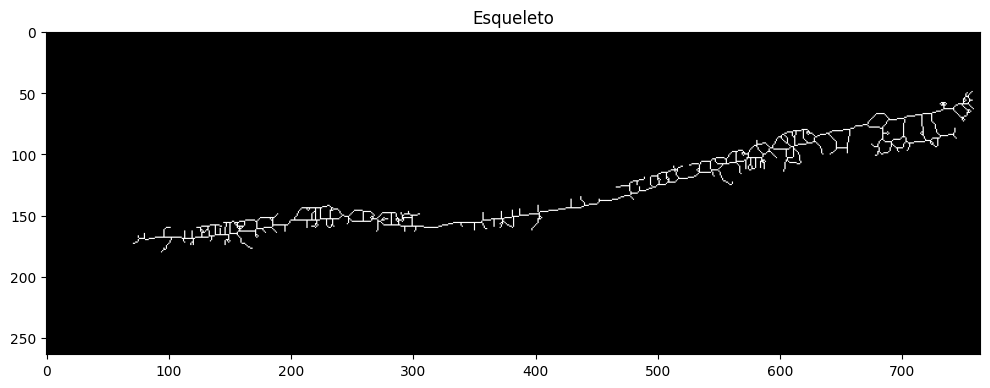

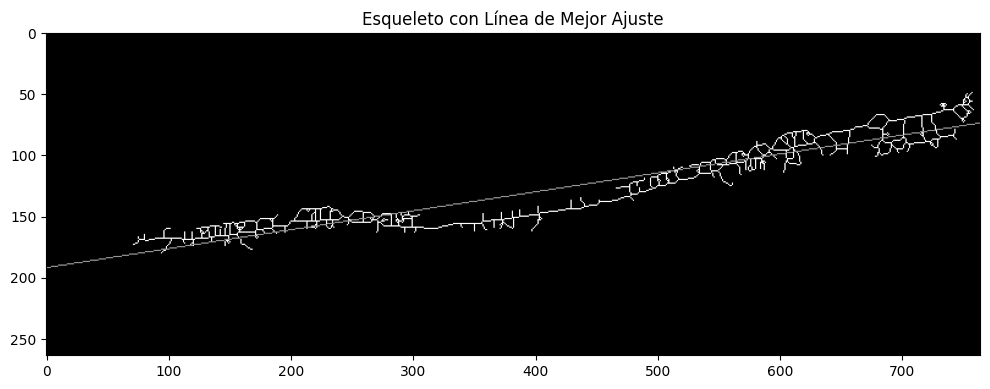

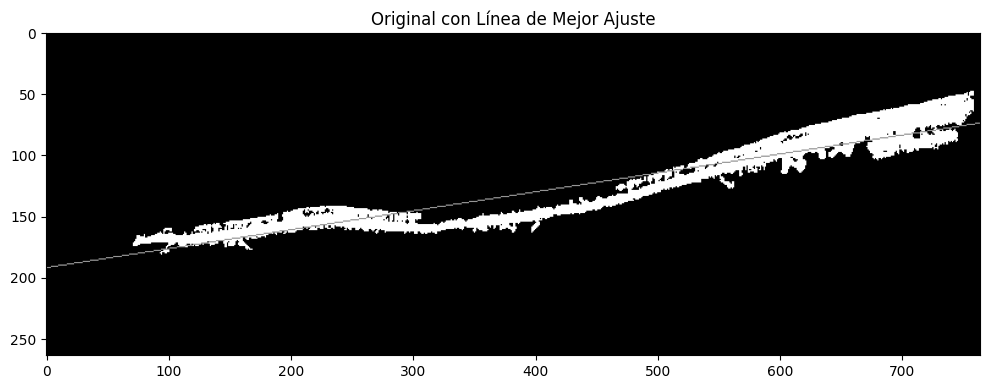

Coeficiente de determinación (R2): 0.901


In [ ]:
R2_vi_line = best_fit_corr(vessels_vi[0], plot=True, inform = True)

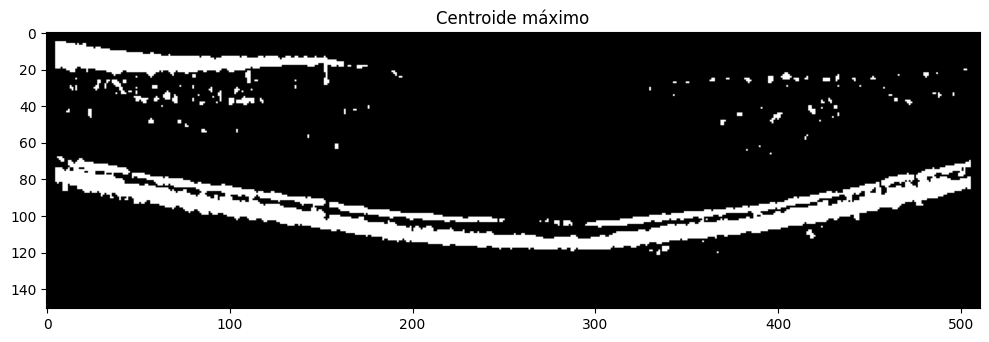

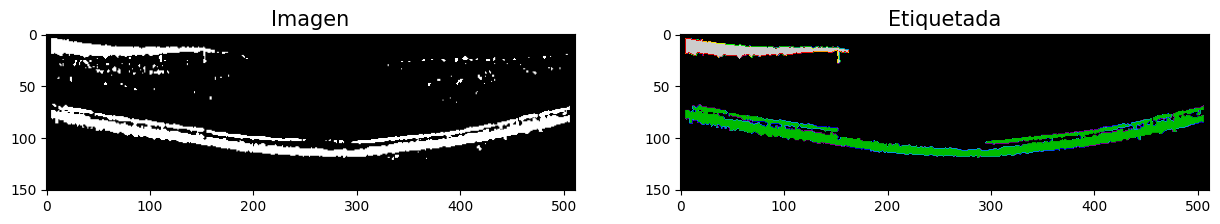

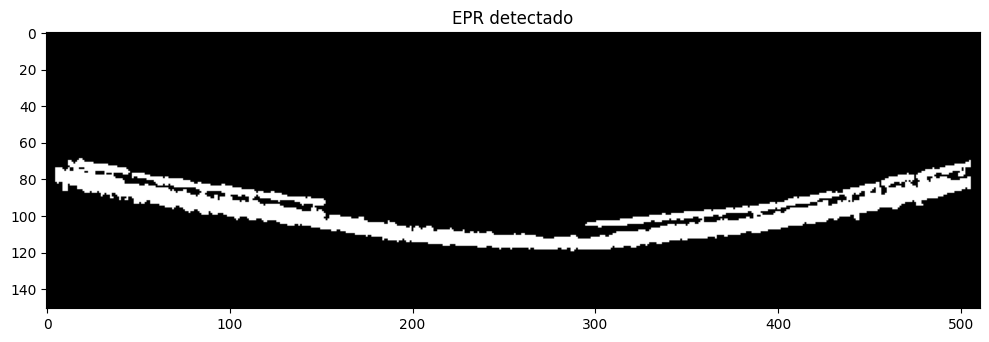

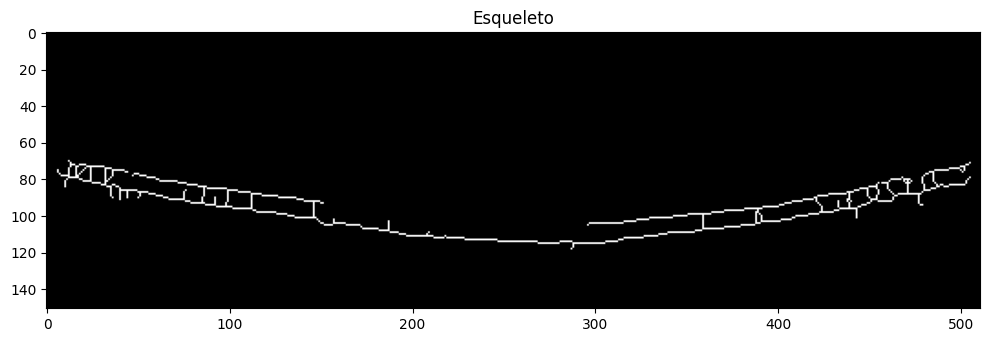

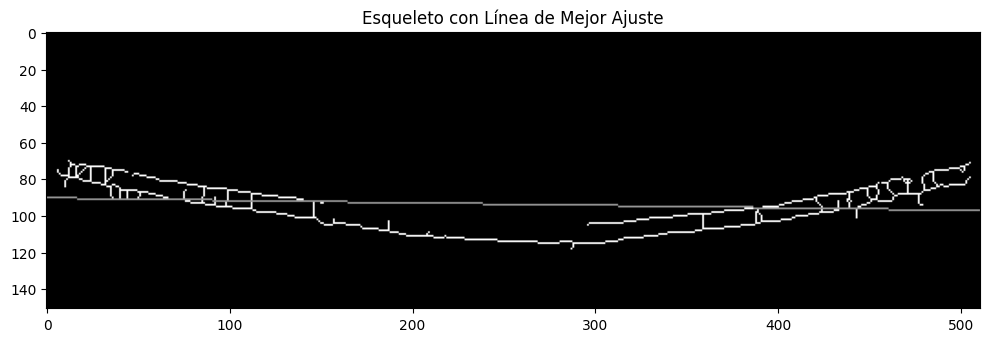

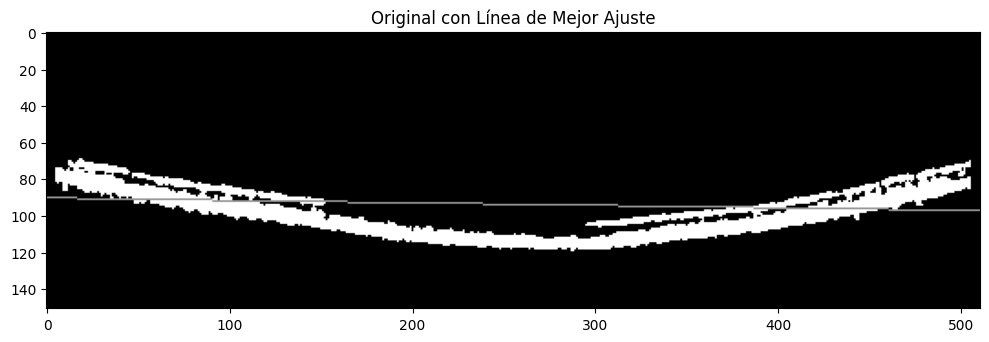

Coeficiente de determinación (R2): 0.034


In [ ]:
R2_vi2_line = best_fit_corr(vessels_vi2[0], plot=True, inform = True)

Considerando que los valores del $R^2$ no son consistentemente altos para EPRs relativamente sanos, decidimos no usar el coeficiente de determinación vinculado a la regresión lineal como medida de deformación del EPR.

#### Basado en la Regresión Parabólica

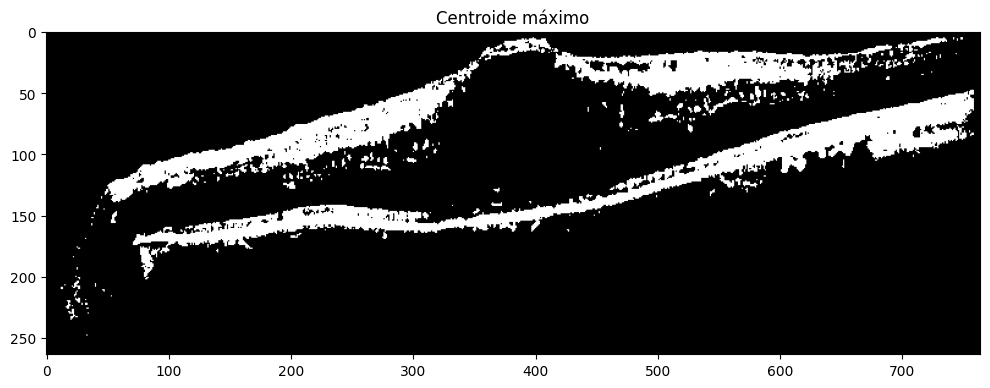

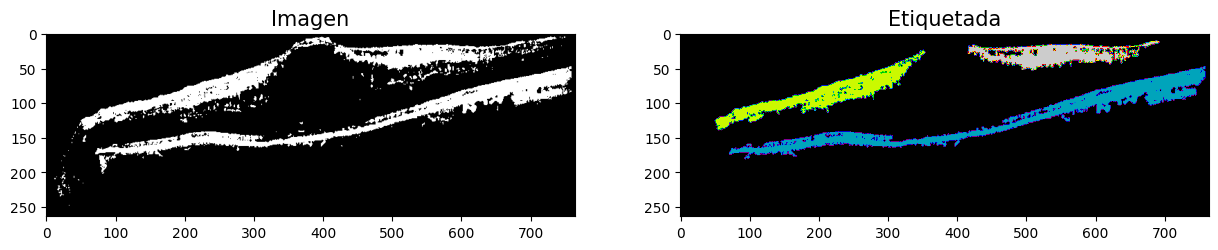

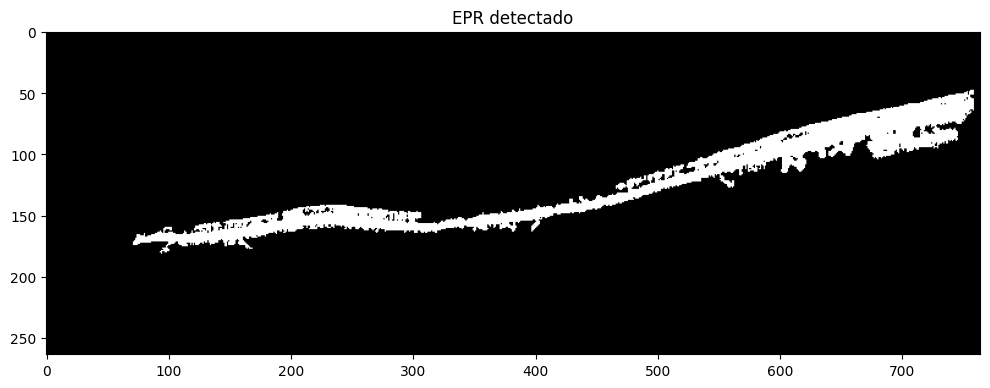

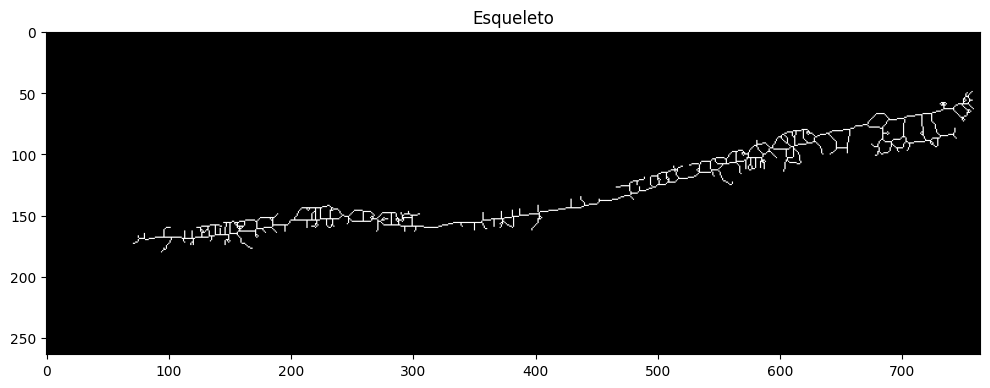

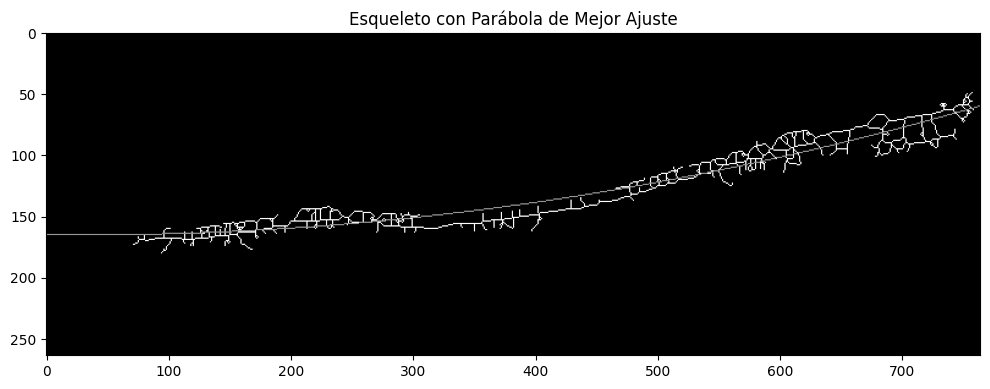

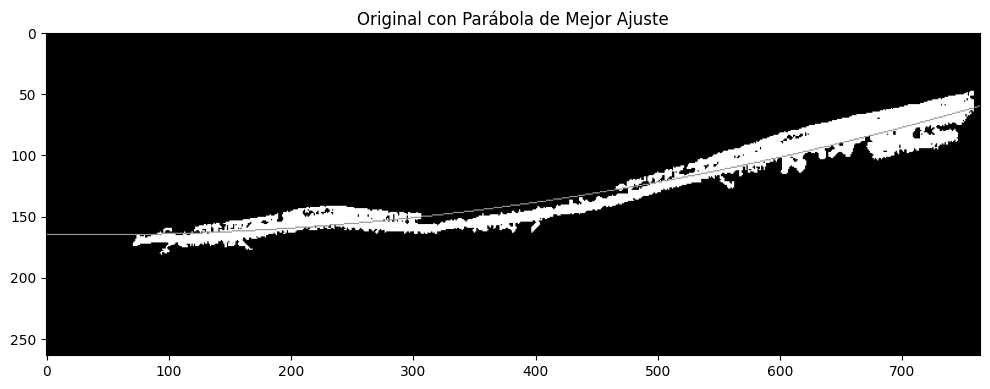

Coeficiente de determinación (R2): 0.939


In [ ]:
R2_vi_par = best_fit_corr(vessels_vi[0], mode = 'parabolic', plot=True, inform = True)

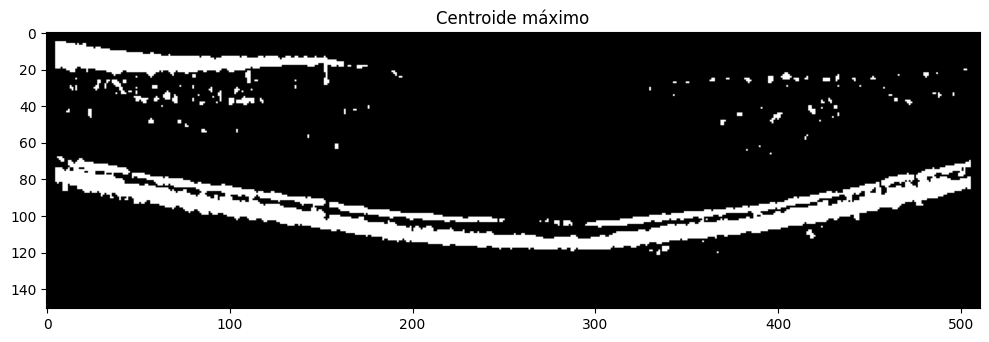

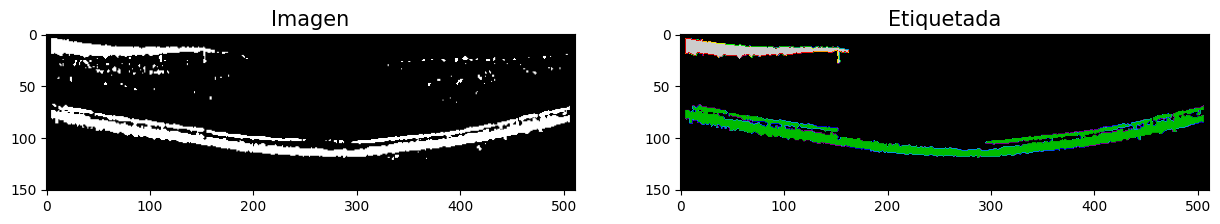

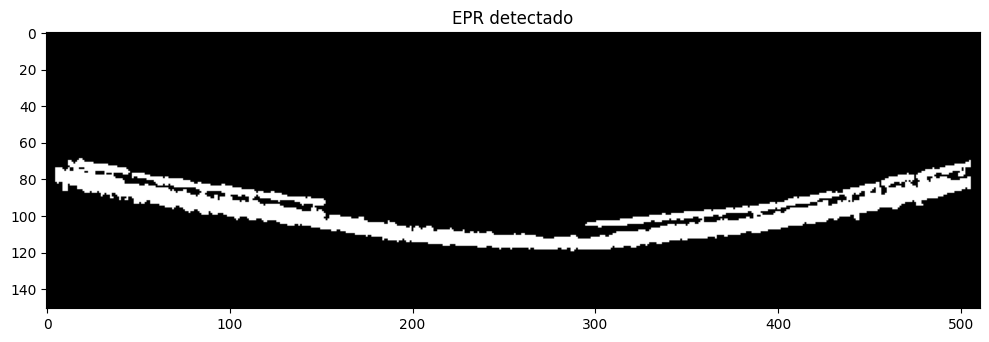

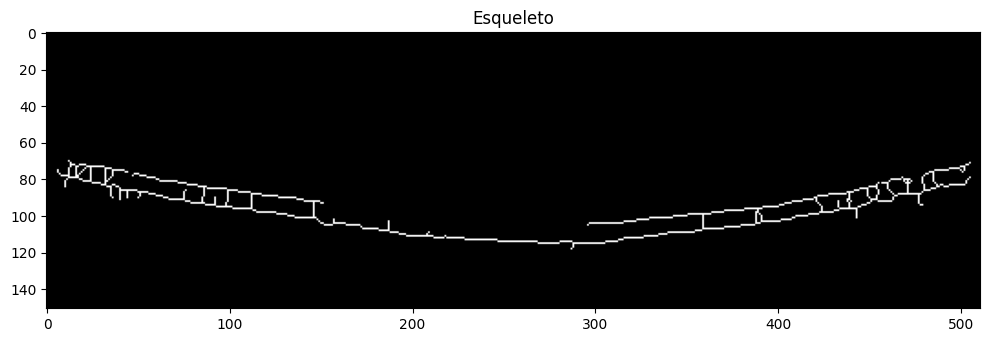

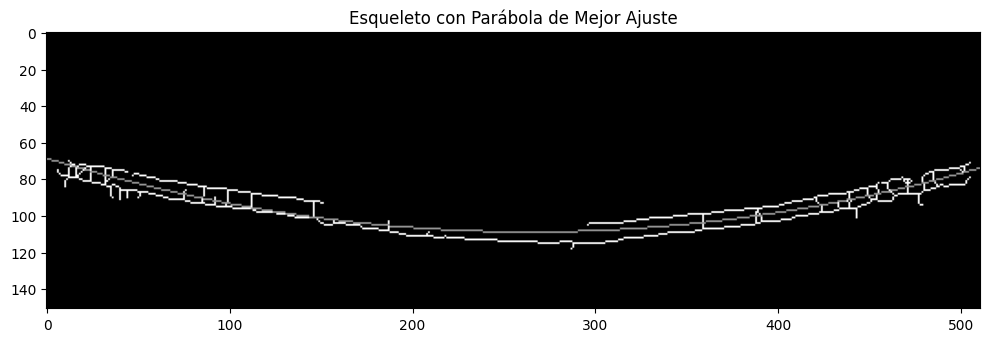

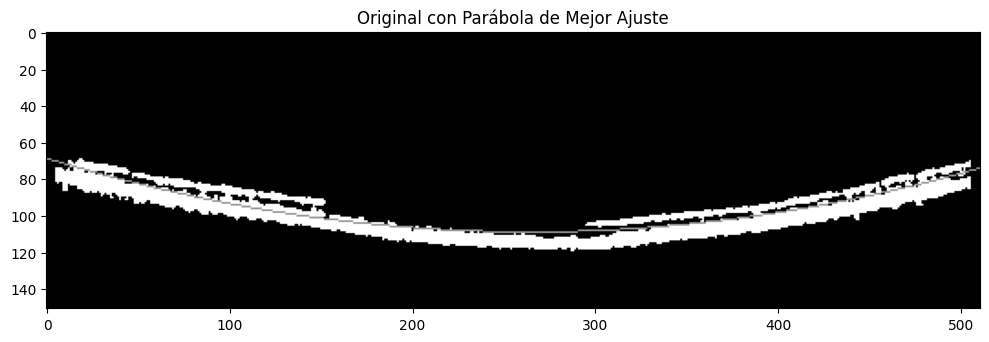

Coeficiente de determinación (R2): 0.844


In [ ]:
R2_vi2_par = best_fit_corr(vessels_vi2[0], mode = 'parabolic', plot=True, inform = True)

En este caso se obtienen valores más consistentes con una retina sana (más altos) para el $R^2$. Por lo tanto, se decide trabajar con la regresión parabólica.

### Clasificación

Finalmente, hacemos un análisis en grilla de distintos valores de umbrales para el clasificador. En una primera instancia, se prueban valores más distanciados entre sí para poder acotar el rango de los umbrales. Después, eligiendo un valor particular para el umbral del conteo de vasos y un rango para el umbral del coeficiente de determinación, se lleva a cabo una evaluación más detallada.

#### Entrenamiento

##### Marco general

In [ ]:
param_grid_gral = {
    'umbral_vessels': [0, 1, 2, 3, 4],
    'umbral_r': [0.5, 0.6, 0.7, 0.8, 0.9]}

In [ ]:
metricas_gral = grid_search(param_grid_gral,nuevo_X_train,nuevo_y_train)

Combinación 1/25 procesada.
Tiempo estimado restante: 0.84 segundos.
Combinación 2/25 procesada.
Tiempo estimado restante: 0.34 segundos.
Combinación 3/25 procesada.
Tiempo estimado restante: 0.29 segundos.
Combinación 4/25 procesada.
Tiempo estimado restante: 0.32 segundos.
Combinación 5/25 procesada.
Tiempo estimado restante: 0.29 segundos.
Combinación 6/25 procesada.
Tiempo estimado restante: 0.26 segundos.
Combinación 7/25 procesada.
Tiempo estimado restante: 0.28 segundos.
Combinación 8/25 procesada.
Tiempo estimado restante: 0.24 segundos.
Combinación 9/25 procesada.
Tiempo estimado restante: 0.22 segundos.
Combinación 10/25 procesada.
Tiempo estimado restante: 0.20 segundos.
Combinación 11/25 procesada.
Tiempo estimado restante: 0.19 segundos.
Combinación 12/25 procesada.
Tiempo estimado restante: 0.18 segundos.
Combinación 13/25 procesada.
Tiempo estimado restante: 0.19 segundos.
Combinación 14/25 procesada.
Tiempo estimado restante: 0.16 segundos.
Combinación 15/25 procesada.


In [ ]:
display(metricas_gral)

[{'parametros': [0, 0.5],
  'metricas':                    0         1         2
  Accuracy    0.733333  0.671642  0.760000
  Precisión   0.555556  0.666667  0.666667
  Tasa de VP  1.000000  0.240000  0.560000
  Tasa de FP  0.400000  0.071429  0.140000
  F1-score    0.714286  0.352941  0.608696},
 {'parametros': [0, 0.6],
  'metricas':                    0         1         2
  Accuracy    0.733333  0.686567  0.773333
  Precisión   0.555556  0.700000  0.700000
  Tasa de VP  1.000000  0.280000  0.560000
  Tasa de FP  0.400000  0.071429  0.120000
  F1-score    0.714286  0.400000  0.622222},
 {'parametros': [0, 0.7],
  'metricas':                    0         1         2
  Accuracy    0.733333  0.686567  0.773333
  Precisión   0.555556  0.642857  0.750000
  Tasa de VP  1.000000  0.360000  0.480000
  Tasa de FP  0.400000  0.119048  0.080000
  F1-score    0.714286  0.461538  0.585366},
 {'parametros': [0, 0.8],
  'metricas':                    0         1         2
  Accuracy    0.733333  0

In [ ]:
promedios_gral = average(metricas_gral)

In [ ]:
display(promedios_gral)

,Threshold_vessels: 0. Threshold_R2: 0.5.,Threshold_vessels: 0. Threshold_R2: 0.6.,Threshold_vessels: 0. Threshold_R2: 0.7.,Threshold_vessels: 0. Threshold_R2: 0.8.,Threshold_vessels: 0. Threshold_R2: 0.9.,Threshold_vessels: 1. Threshold_R2: 0.5.,Threshold_vessels: 1. Threshold_R2: 0.6.,Threshold_vessels: 1. Threshold_R2: 0.7.,Threshold_vessels: 1. Threshold_R2: 0.8.,Threshold_vessels: 1. Threshold_R2: 0.9.,...,Threshold_vessels: 3. Threshold_R2: 0.5.,Threshold_vessels: 3. Threshold_R2: 0.6.,Threshold_vessels: 3. Threshold_R2: 0.7.,Threshold_vessels: 3. Threshold_R2: 0.8.,Threshold_vessels: 3. Threshold_R2: 0.9.,Threshold_vessels: 4. Threshold_R2: 0.5.,Threshold_vessels: 4. Threshold_R2: 0.6.,Threshold_vessels: 4. Threshold_R2: 0.7.,Threshold_vessels: 4. Threshold_R2: 0.8.,Threshold_vessels: 4. Threshold_R2: 0.9.
Accuracy,0.721658,0.731078,0.731078,0.721658,0.693400,0.629104,0.629104,0.629104,0.619283,0.580000,...,0.547901,0.547901,0.558519,0.558519,0.537284,0.536101,0.536101,0.536101,0.536101,0.525367
Precisión,0.629630,0.651852,0.649471,0.637674,0.629630,0.527778,0.527778,0.572222,0.546296,0.472222,...,0.385714,0.385714,0.785714,0.785714,0.563492,0.449074,0.449074,0.449074,0.449074,0.449074
Tasa de VP,0.600000,0.613333,0.613333,0.600000,0.560000,0.480000,0.480000,0.480000,0.466667,0.413333,...,0.386667,0.386667,0.400000,0.400000,0.373333,0.373333,0.373333,0.373333,0.373333,0.360000
Tasa de FP,0.203810,0.197143,0.199683,0.208889,0.235238,0.264685,0.264685,0.267027,0.276036,0.312072,...,0.306667,0.306667,0.300000,0.300000,0.322989,0.313333,0.313333,0.313333,0.313333,0.325238
F1-score,0.558641,0.578836,0.587063,0.572264,0.508887,0.400068,0.400068,0.411951,0.395952,0.323063,...,0.264327,0.264327,0.293034,0.293034,0.248631,0.243250,0.243250,0.243250,0.243250,0.221204


##### Marco detallado

In [ ]:
param_grid_0 = {
    'umbral_vessels': [0],
    'umbral_r': [0.6, 0.65, 0.675, 0.7, 0.725]}

In [ ]:
metricas_0 = grid_search(param_grid_0,nuevo_X_train,nuevo_y_train)

Combinación 1/5 procesada.
Tiempo estimado restante: 0.07 segundos.
Combinación 2/5 procesada.
Tiempo estimado restante: 0.05 segundos.
Combinación 3/5 procesada.
Tiempo estimado restante: 0.03 segundos.
Combinación 4/5 procesada.
Tiempo estimado restante: 0.02 segundos.
Combinación 5/5 procesada.
Tiempo estimado restante: 0.00 segundos.


In [ ]:
display(metricas_0)

[{'parametros': [0, 0.6],
  'metricas':                    0         1         2
  Accuracy    0.760000  0.710145  0.813333
  Precisión   0.581395  0.727273  0.761905
  Tasa de VP  1.000000  0.320000  0.640000
  Tasa de FP  0.360000  0.068182  0.100000
  F1-score    0.735294  0.444444  0.695652},
 {'parametros': [0, 0.65],
  'metricas':                    0         1         2
  Accuracy    0.760000  0.695652  0.800000
  Precisión   0.581395  0.666667  0.750000
  Tasa de VP  1.000000  0.320000  0.600000
  Tasa de FP  0.360000  0.090909  0.100000
  F1-score    0.735294  0.432432  0.666667},
 {'parametros': [0, 0.675],
  'metricas':                    0         1         2
  Accuracy    0.760000  0.710145  0.813333
  Precisión   0.581395  0.692308  0.789474
  Tasa de VP  1.000000  0.360000  0.600000
  Tasa de FP  0.360000  0.090909  0.080000
  F1-score    0.735294  0.473684  0.681818},
 {'parametros': [0, 0.7],
  'metricas':                    0         1         2
  Accuracy    0.760000

In [ ]:
promedios = average(metricas_0)

In [ ]:
display(promedios)

,Threshold_vessels: 0. Threshold_R2: 0.6.,Threshold_vessels: 0. Threshold_R2: 0.65.,Threshold_vessels: 0. Threshold_R2: 0.675.,Threshold_vessels: 0. Threshold_R2: 0.7.,Threshold_vessels: 0. Threshold_R2: 0.725.
Accuracy,0.761159,0.751884,0.761159,0.751884,0.761159
Precisión,0.690191,0.666021,0.687726,0.667343,0.690530
Tasa de VP,0.653333,0.640000,0.653333,0.640000,0.653333
Tasa de FP,0.176061,0.183636,0.176970,0.184545,0.177879
F1-score,0.625130,0.611464,0.630266,0.615998,0.633987


#### Test

In [ ]:
param_grid_test = {
    'umbral_vessels': [0],
    'umbral_r': [0.725]}

In [ ]:
resultados_test = grid_search(param_grid_test,X_test_nuevo,y_test_nuevo)

Combinación 1/1 procesada.
Tiempo estimado restante: 0.00 segundos.


In [ ]:
display(resultados_test)

[{'parametros': [0, 0.725],
  'metricas':                    0         1         2
  Accuracy    0.733333  0.761194  0.840000
  Precisión   0.558140  1.000000  0.782609
  Tasa de VP  0.960000  0.360000  0.720000
  Tasa de FP  0.380000  0.000000  0.100000
  F1-score    0.705882  0.529412  0.750000}]

In [ ]:
resultados_promedio = average(resultados_test)

In [ ]:
display(resultados_promedio)

,Threshold_vessels: 0. Threshold_R2: 0.725.
Accuracy,0.778176
Precisión,0.780249
Tasa de VP,0.680000
Tasa de FP,0.160000
F1-score,0.661765
